In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [85]:
#read data
gameData = pd.read_csv("data-sources/games.csv.txt")
#check what data is included
print(gameData.columns, "\n")
print(gameData.shape)


Index(['id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated',
       'average_rating', 'bayes_average_rating', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object') 

(81312, 20)


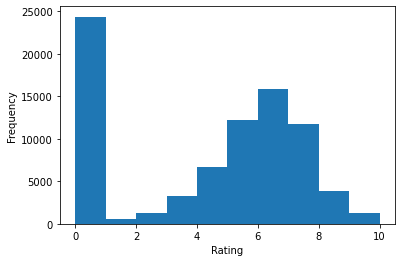

In [86]:
#map out all game ratings on histogram of rating v count
plt.hist(gameData["average_rating"])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#we notice that there is a large number of zero ratings whose sum comes close to the number of all other ratings combined which we should investigate

In [87]:
print(gameData[gameData['average_rating'] == 0].iloc[0])

id                             318
type                     boardgame
name                    Looney Leo
yearpublished                    0
minplayers                       0
maxplayers                       0
playingtime                      0
minplaytime                      0
maxplaytime                      0
minage                           0
users_rated                      0
average_rating                   0
bayes_average_rating             0
total_owners                     0
total_traders                    0
total_wanters                    0
total_wishers                    1
total_comments                   0
total_weights                    0
average_weight                   0
Name: 13048, dtype: object


In [88]:
#print the first frow from games with zero scores
print(gameData[gameData['average_rating'] == 0])
#this shows that these users have never played the game, which leads us to belive that these points are noise
#we can see that there are 24380 rows that either have missing data pr have zero reviews

id                type  \
13048     318           boardgame   
13068     579           boardgame   
13114     894           boardgame   
13116     897           boardgame   
13124     946           boardgame   
...       ...                 ...   
81307  184441  boardgameexpansion   
81308  184442           boardgame   
81309  184443           boardgame   
81310  184449           boardgame   
81311  184451           boardgame   

                                                    name  yearpublished  \
13048                                         Looney Leo            0.0   
13068                                      Field of Fire         2002.0   
13114                                          LifeLinks         2000.0   
13116                                          Dear Abby         1992.0   
13124                                           Rolazone         1999.0   
...                                                  ...            ...   
81307                               Micro

In [89]:
#to investigate further we will bin together the ratings from other non zero rating users, this will allow us to see the diffrences and decide on a path forward
print(gameData[gameData['average_rating'] > 0].iloc[0])

id                                  12333
type                            boardgame
name                    Twilight Struggle
yearpublished                        2005
minplayers                              2
maxplayers                              2
playingtime                           180
minplaytime                           180
maxplaytime                           180
minage                                 13
users_rated                         20113
average_rating                    8.33774
bayes_average_rating              8.22186
total_owners                        26647
total_traders                         372
total_wanters                        1219
total_wishers                        5865
total_comments                       5347
total_weights                        2562
average_weight                     3.4785
Name: 0, dtype: object


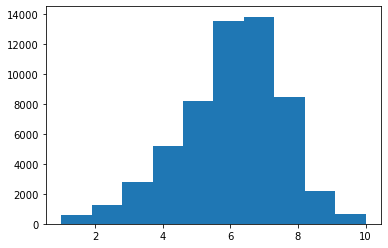

In [90]:
#remove all rows with no user reviews and missing values
gameDataNoZero = gameData[gameData["users_rated"] > 0]
gameDataNoZero = gameDataNoZero.dropna(axis=0)
plt.hist(gameDataNoZero["average_rating"])
plt.show()
#this show a much more regular distribution once we eleminate all the data points that are not complete

In [91]:
#correlation matrix
corrmat = gameDataNoZero.corr()
print(corrmat)

id  yearpublished  minplayers  maxplayers  \
id                    1.000000       0.002767   -0.050234    0.006141   
yearpublished         0.002767       1.000000    0.004308    0.004977   
minplayers           -0.050234       0.004308    1.000000    0.037155   
maxplayers            0.006141       0.004977    0.037155    1.000000   
playingtime          -0.022017       0.006235    0.024320   -0.001020   
minplaytime          -0.026729       0.005245    0.026569   -0.000950   
maxplaytime          -0.022017       0.006235    0.024320   -0.001020   
minage                0.099168       0.125281    0.110886    0.004508   
users_rated          -0.057778       0.037454    0.020364   -0.000858   
average_rating        0.304201       0.108461   -0.032701   -0.008335   
bayes_average_rating -0.117172       0.140998    0.034915   -0.003437   
total_owners         -0.040308       0.047740    0.014594   -0.000977   
total_traders        -0.112069       0.064403    0.024708   -0.002381   
total_

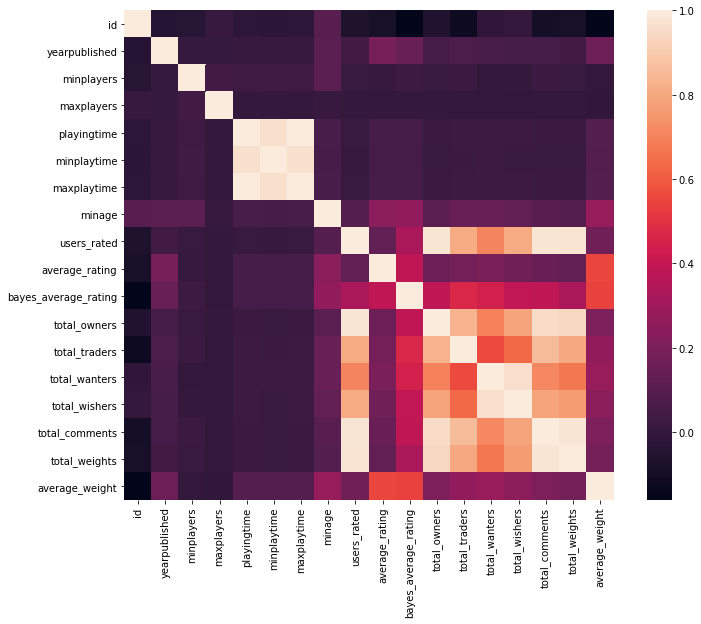

In [92]:
nonCleanCorrmat = gameData.corr()
fig = plt.figure(figsize= (12,9))
sns.heatmap(nonCleanCorrmat, vmax= 1, square=True)
plt.show()

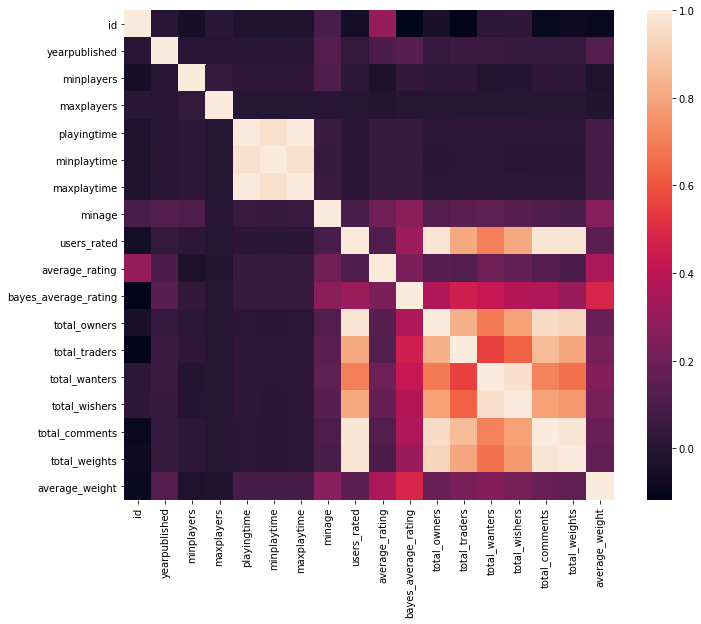

In [93]:
#plot correlation matrix for cleaned data
fig = plt.figure(figsize= (12,9))
sns.heatmap(corrmat, vmax= 1, square=True)
plt.show()

In [94]:
#transform data for regression
columns = gameDataNoZero.columns.tolist()
#filter to get rid of non imporant columns
columns = [c for c in columns if c not in ["bayes_average_rating", "average_rating", "type", "name", "id"]]

#create perdiciton target
target = "average_rating"

In [95]:
#generate training set, set random state to be able to replicate results
train = gameDataNoZero.sample(frac=0.8, random_state=1)
#create test set from all non train set items
test = gameDataNoZero.loc[~gameDataNoZero.index.isin(train.index)]
print("train set shape")
print(train.shape,"\n")
print("test set shape")
print(test.shape, "\n")

train set shape
(45515, 20) 

test set shape
(11379, 20) 



In [96]:
#ceate linear regression
model = LinearRegression()
#fit model to training data
model.fit(train[columns], train[target])

predictions = model.predict(test[columns])
MSerrorLR = mean_squared_error(predictions, test[target])
print(MSerrorLR)


2.0788190326293243


In [97]:
#use a second random forest regression model
model2 = RandomForestRegressor(n_estimators=100, min_samples_leaf=20, random_state=1)
#fit model
model2.fit(train[columns], train[target])
predictions = model2.predict(test[columns])
#compute error
MSerrorRF = mean_squared_error(predictions, test[target])
print(MSerrorRF)

1.465461353679289
